In [4]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA

## Feature Extraction

### Local Binary Pattern

In [16]:
def create_charts(mlp, X_train, y_train, X_val, y_val):
    """
    plot1: train & validation loss curves
    plot2: train & validation accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    """
    
    # Initialize lists to store metrics during training
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []

    # Split the validation set for incremental training
    X_train_partial, X_val_partial, y_train_partial, y_val_partial = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

    # Number of epochs for partial fitting
    epochs = 100

    # Train the model incrementally and collect metrics
    for epoch in range(epochs):
        mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
        train_loss = mlp.loss_
        train_accuracy = mlp.score(X_train, y_train)
        val_loss = mlp.loss_
        val_accuracy = mlp.score(X_val_partial, y_val_partial)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)

    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss_list, label='training loss')
    plt.plot(val_loss_list, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation Accuracy")
    plt.plot(train_accuracy_list, label='training accuracy')
    plt.plot(val_accuracy_list, label='validation accuracy')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    y_pred = mlp.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    y_pred_prob = mlp.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
    auc = roc_auc_score(y_val, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='MLP (AUC = {:.2f}%)'.format(auc * 100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel()
    accuracy = (TP + TN) / np.sum(cm)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1 = 2 * precision * recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)


In [74]:
def read_images_from_folder(folder_path):
    images = []
    labels = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder  # Use the subfolder name as the label
            for fn in os.listdir(subfolder_path):
                if fn.endswith('.jpg'):
                    img_path = os.path.join(subfolder_path, fn)
                    im = Image.open(img_path).convert('L')
                    data = np.array(im)
                    images.append(data)
                    labels.append(label)

    return images, labels

# Load images and labels from the 'resize_data' 
data_folder = './resize_data'
images, labels = read_images_from_folder(data_folder)
print('Load data success!')

X = np.array(images)
print(X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

radius = 2
n_point = radius * 8

Load data success!
(1790, 256, 256)
(1432, 256, 256)
(358, 256, 256)
(1432,)
(358,)


In [75]:
def lbp_texture(train_data, test_data):
    max_bins_train = 0
    max_bins_test = 0

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        max_bins_train = max(max_bins_train, int(lbp.max()) + 1)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        max_bins_test = max(max_bins_test, int(lbp.max()) + 1)

    train_hist = np.zeros((len(train_data), max_bins_train))
    test_hist = np.zeros((len(test_data), max_bins_test))

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        train_hist[i], _ = np.histogram(lbp, bins=max_bins_train, density=True)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        test_hist[i], _ = np.histogram(lbp, bins=max_bins_test, density=True)

    return train_hist, test_hist


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.9518156424581006
Test Accuracy: 0.8491620111731844
Precision: 0.8509358288770054
Recall: 0.8459149096385542
F1 Score: 0.8474431818181818

Overall Accuracy:               precision    recall  f1-score   support

           0       0.84      0.89      0.86       192
           1       0.86      0.80      0.83       166

    accuracy                           0.85       358
   macro avg       0.85      0.85      0.85       358
weighted avg       0.85      0.85      0.85       358

Test Accuracy: 84.92%


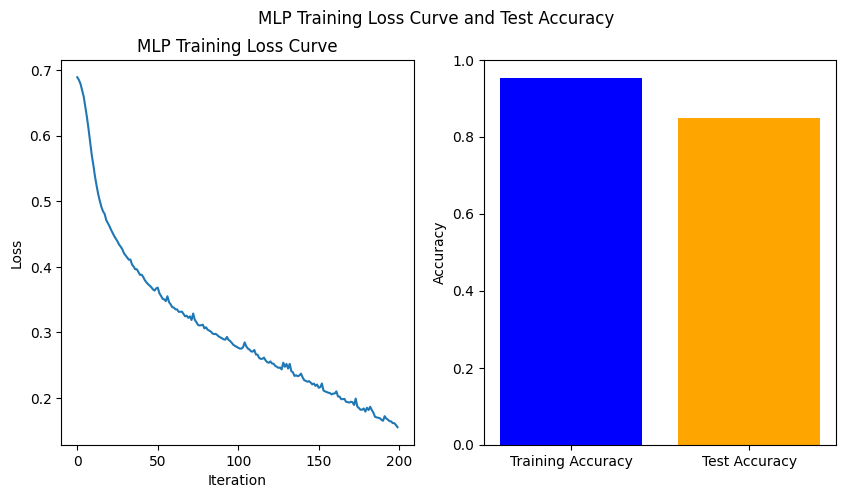

In [8]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

[Summary Statistics]
Accuracy = 84.92% | Precision = 86.32% | Recall = 85.42% | Specificity = 84.34% | F1 Score = 85.86%


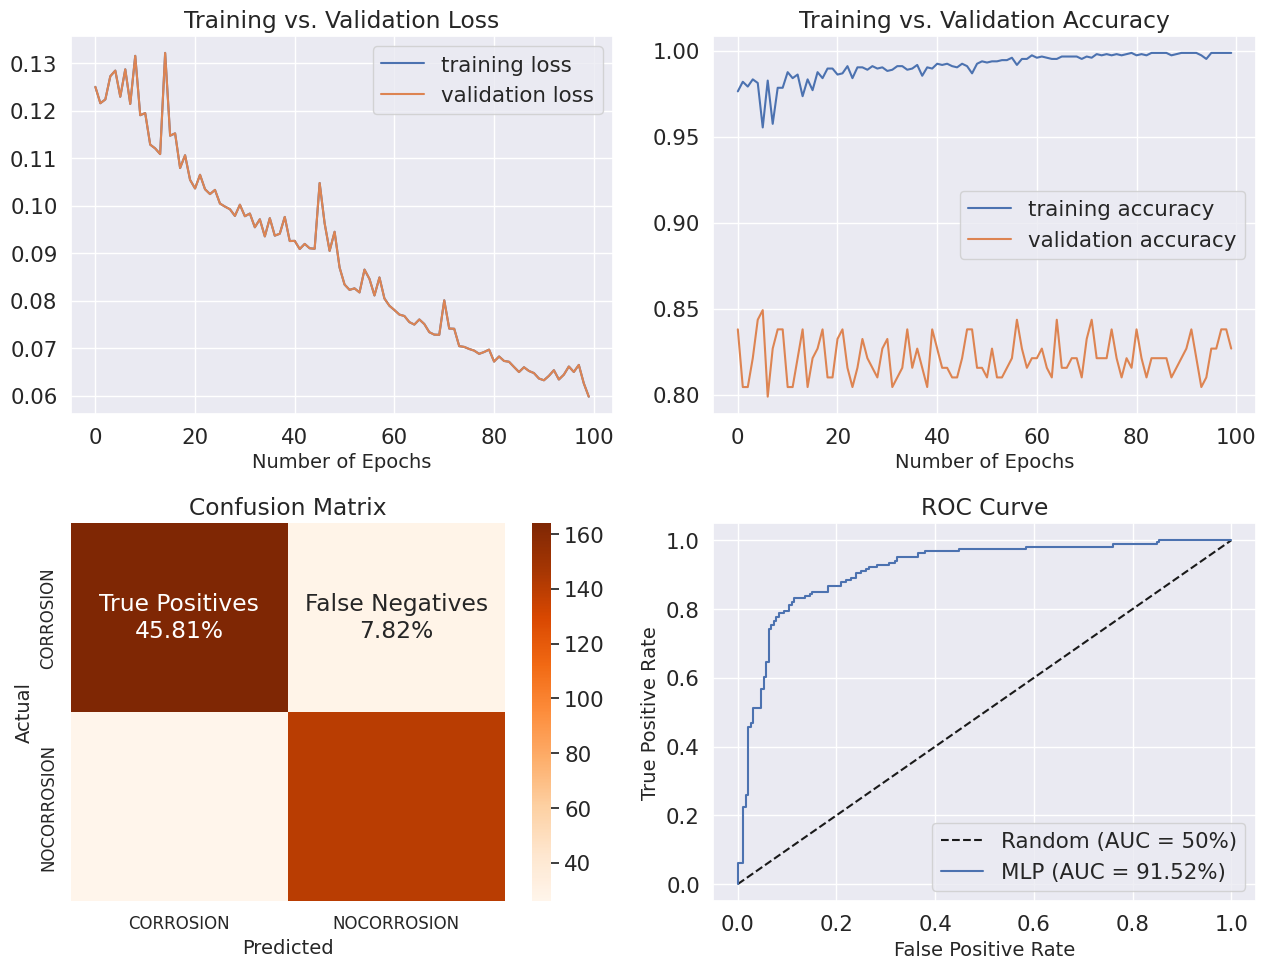

In [17]:
create_charts(mlp, X_train, y_train, X_test, y_test)

In [20]:
def print_mlp_summary(mlp):
    print("MLP Model Summary:")
    print("===================")
    print("Number of Layers:", mlp.n_layers_)
    print("Number of Neurons in Each Layer:", mlp.hidden_layer_sizes)
    print("Activation Function:", mlp.activation)
    print("Solver (Optimization Algorithm):", mlp.solver)
    print("Alpha (L2 Regularization):", mlp.alpha)
    print("Learning Rate:", mlp.learning_rate)
    print("Learning Rate Schedule:", mlp.learning_rate_init)
    print("Maximum Number of Iterations:", mlp.max_iter)
    print("Training Loss:", mlp.loss_)
    print("Output Activation Function:", "logistic" if mlp.out_activation_ == "logistic" else "tanh" if mlp.out_activation_ == "tanh" else "identity")

def count_parameters(model):
    total_params = 0
    for layer in model.coefs_:
        total_params += layer.size
    return total_params


# Print the summary
print_mlp_summary(mlp)
total_parameters = count_parameters(mlp)
print("Total Number of Parameters in the MLP model:", total_parameters)

MLP Model Summary:
Number of Layers: 4
Number of Neurons in Each Layer: (100, 50)
Activation Function: relu
Solver (Optimization Algorithm): adam
Alpha (L2 Regularization): 0.0001
Learning Rate: constant
Learning Rate Schedule: 0.001
Maximum Number of Iterations: 200
Training Loss: 0.05982303279807017
Output Activation Function: logistic
Total Number of Parameters in the MLP model: 6558650


In [5]:
# Save the trained MLP model to a file
model_filename = './model/mlp_lbp_model.pkl'
joblib.dump(mlp, model_filename)

print(f"MLP model saved as {model_filename}")

MLP model saved as ./model/mlp_lbp_model.pkl


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.9727653631284916
Test Accuracy: 0.8324022346368715
Precision: 0.8331043956043955
Recall: 0.8347766064257028
F1 Score: 0.8322713643178412

Overall Accuracy:               precision    recall  f1-score   support

           0       0.88      0.80      0.84       192
           1       0.79      0.87      0.83       166

    accuracy                           0.83       358
   macro avg       0.83      0.83      0.83       358
weighted avg       0.84      0.83      0.83       358

Test Accuracy: 83.24%


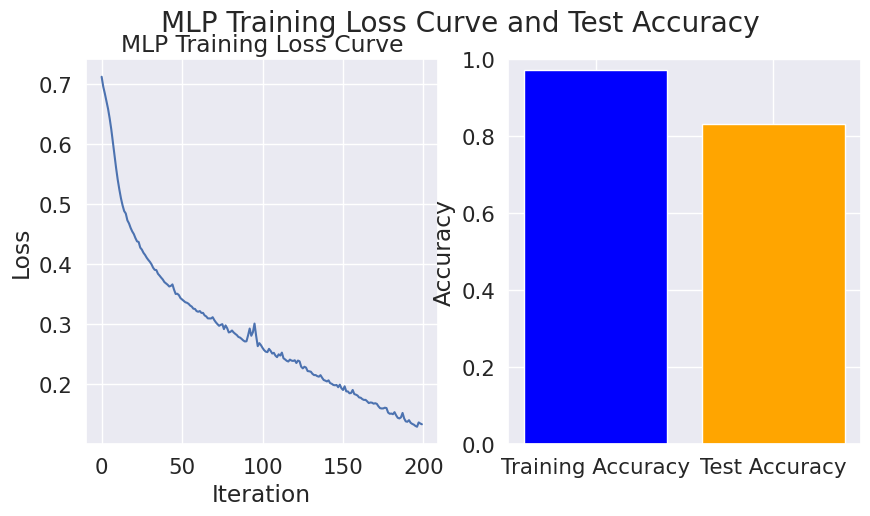

In [23]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

[Summary Statistics]
Accuracy = 85.20% | Precision = 83.90% | Recall = 89.58% | Specificity = 80.12% | F1 Score = 86.65%


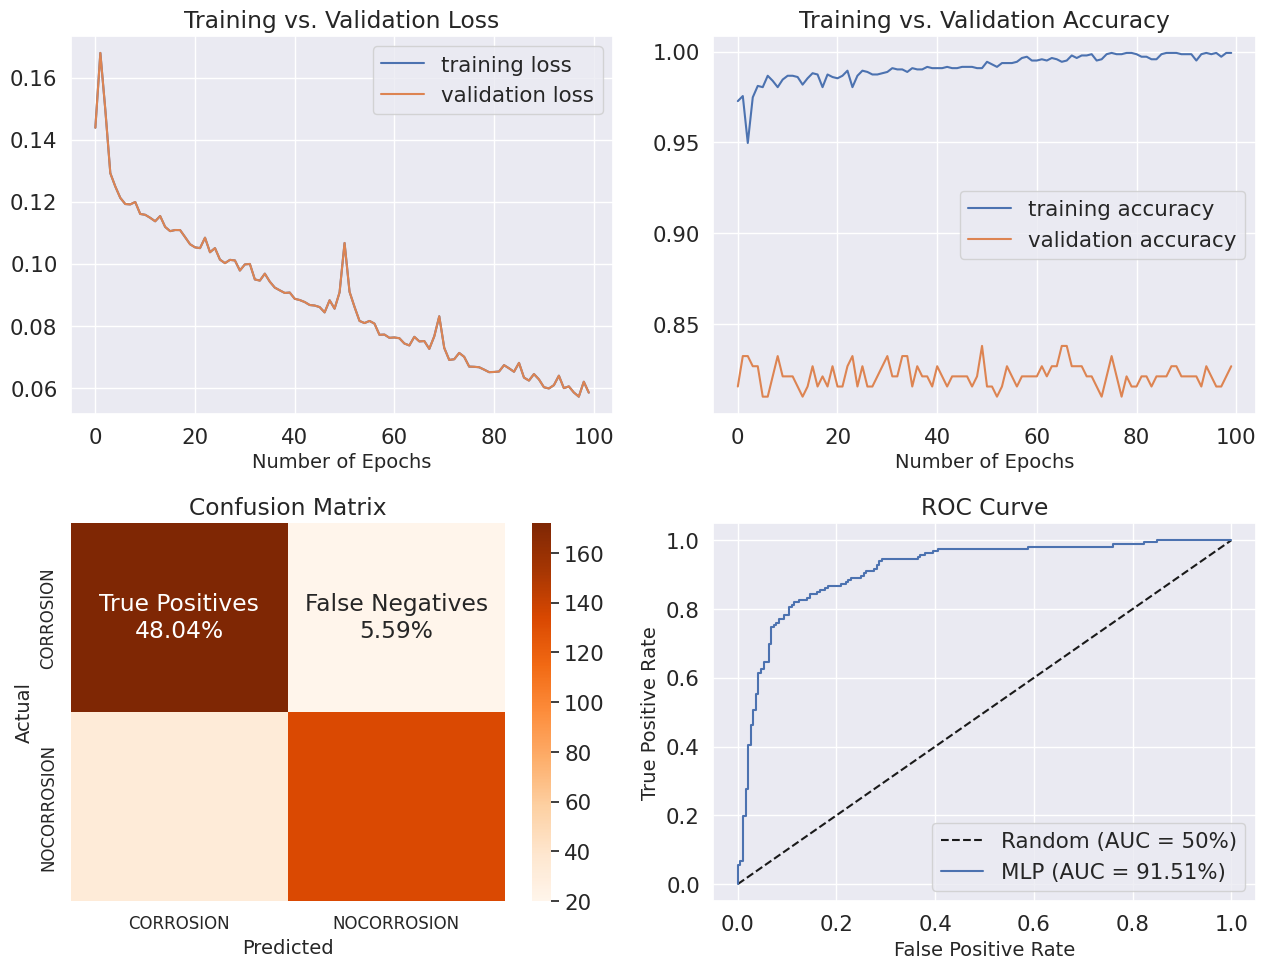

In [24]:
create_charts(mlp, X_train, y_train, X_test, y_test)

In [25]:
def print_mlp_summary(mlp):
    print("MLP Model Summary:")
    print("===================")
    print("Number of Layers:", mlp.n_layers_)
    print("Number of Neurons in Each Layer:", mlp.hidden_layer_sizes)
    print("Activation Function:", mlp.activation)
    print("Solver (Optimization Algorithm):", mlp.solver)
    print("Alpha (L2 Regularization):", mlp.alpha)
    print("Learning Rate:", mlp.learning_rate)
    print("Learning Rate Schedule:", mlp.learning_rate_init)
    print("Maximum Number of Iterations:", mlp.max_iter)
    print("Training Loss:", mlp.loss_)
    print("Output Activation Function:", "logistic" if mlp.out_activation_ == "logistic" else "tanh" if mlp.out_activation_ == "tanh" else "identity")

def count_parameters(model):
    total_params = 0
    for layer in model.coefs_:
        total_params += layer.size
    return total_params


# Print the summary
print_mlp_summary(mlp)
total_parameters = count_parameters(mlp)
print("Total Number of Parameters in the MLP model:", total_parameters)

MLP Model Summary:
Number of Layers: 4
Number of Neurons in Each Layer: (200, 50)
Activation Function: relu
Solver (Optimization Algorithm): adam
Alpha (L2 Regularization): 0.0001
Learning Rate: constant
Learning Rate Schedule: 0.001
Maximum Number of Iterations: 200
Training Loss: 0.058498908162029205
Output Activation Function: logistic
Total Number of Parameters in the MLP model: 13117250


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home

Training Accuracy: 0.5391061452513967
Test Accuracy: 0.5363128491620112
Precision: 0.2681564245810056
Recall: 0.5
F1 Score: 0.3490909090909091

Overall Accuracy:               precision    recall  f1-score   support

           0       0.54      1.00      0.70       192
           1       0.00      0.00      0.00       166

    accuracy                           0.54       358
   macro avg       0.27      0.50      0.35       358
weighted avg       0.29      0.54      0.37       358

Test Accuracy: 53.63%


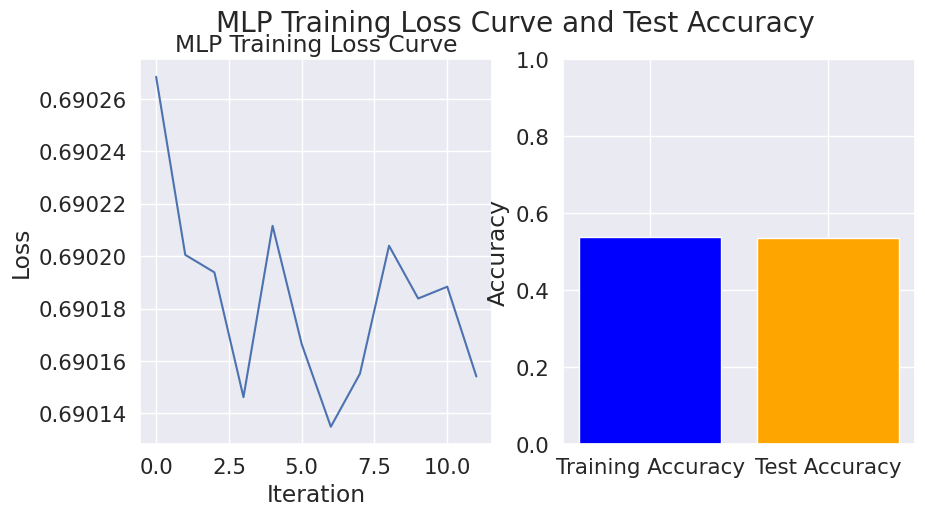

In [29]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200, activation='logistic', solver='sgd')
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

[Summary Statistics]
Accuracy = 53.63% | Precision = 53.63% | Recall = 100.00% | Specificity = 0.00% | F1 Score = 69.82%


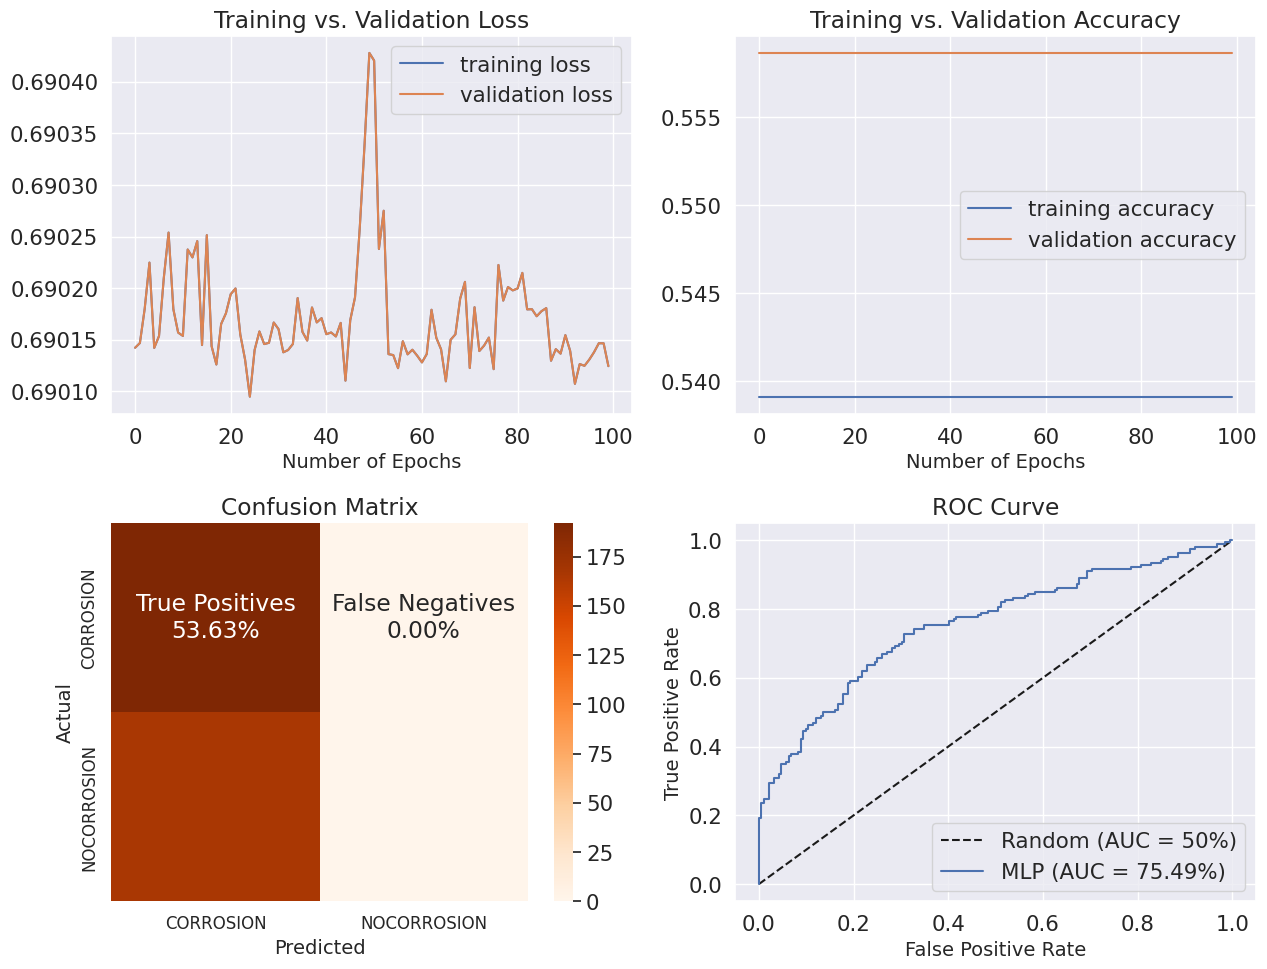

In [30]:
create_charts(mlp, X_train, y_train, X_test, y_test)

In [32]:
def print_mlp_summary(mlp):
    print("MLP Model Summary:")
    print("===================")
    print("Number of Layers:", mlp.n_layers_)
    print("Number of Neurons in Each Layer:", mlp.hidden_layer_sizes)
    print("Activation Function:", mlp.activation)
    print("Solver (Optimization Algorithm):", mlp.solver)
    print("Alpha (L2 Regularization):", mlp.alpha)
    print("Learning Rate:", mlp.learning_rate)
    print("Learning Rate Schedule:", mlp.learning_rate_init)
    print("Maximum Number of Iterations:", mlp.max_iter)
    print("Training Loss:", mlp.loss_)
    print("Output Activation Function:", "logistic" if mlp.out_activation_ == "logistic" else "tanh" if mlp.out_activation_ == "tanh" else "identity")

def count_parameters(model):
    total_params = 0
    for layer in model.coefs_:
        total_params += layer.size
    return total_params


# Print the summary
print_mlp_summary(mlp)
total_parameters = count_parameters(mlp)
print("Total Number of Parameters in the MLP model:", total_parameters)

MLP Model Summary:
Number of Layers: 4
Number of Neurons in Each Layer: (100, 50)
Activation Function: logistic
Solver (Optimization Algorithm): sgd
Alpha (L2 Regularization): 0.0001
Learning Rate: constant
Learning Rate Schedule: 0.001
Maximum Number of Iterations: 200
Training Loss: 0.6901244898105916
Output Activation Function: logistic
Total Number of Parameters in the MLP model: 6558650


In [ ]:
# Save the trained MLP model to a file
model_filename = './model/mlp_lbp_model.pkl'
joblib.dump(mlp, model_filename)

print(f"MLP model saved as {model_filename}")

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.8945530726256983
Test Accuracy: 0.8463687150837989
Precision: 0.8477514698871762
Recall: 0.8433107429718876
F1 Score: 0.8447099649039789

Overall Accuracy:               precision    recall  f1-score   support

           0       0.84      0.89      0.86       192
           1       0.86      0.80      0.83       166

    accuracy                           0.85       358
   macro avg       0.85      0.84      0.84       358
weighted avg       0.85      0.85      0.85       358

Test Accuracy: 84.64%


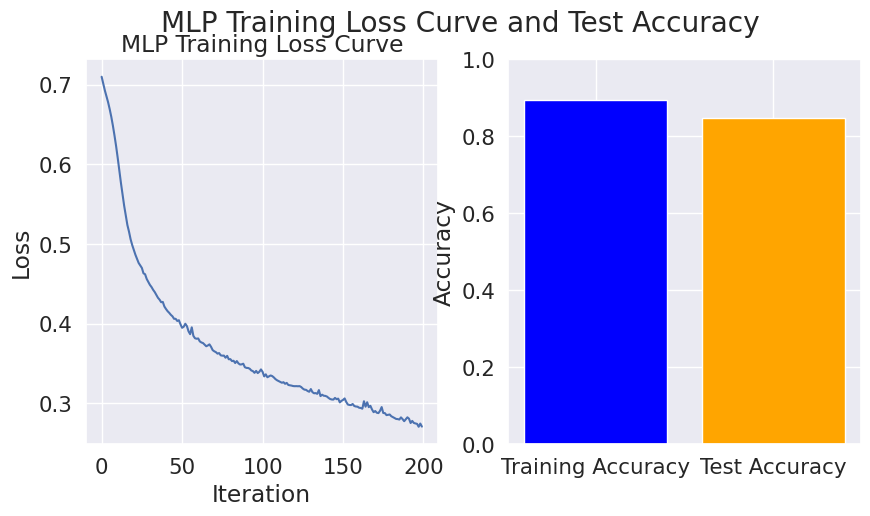

In [35]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), alpha=0.0005, max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

[Summary Statistics]
Accuracy = 85.20% | Precision = 86.01% | Recall = 86.46% | Specificity = 83.73% | F1 Score = 86.23%


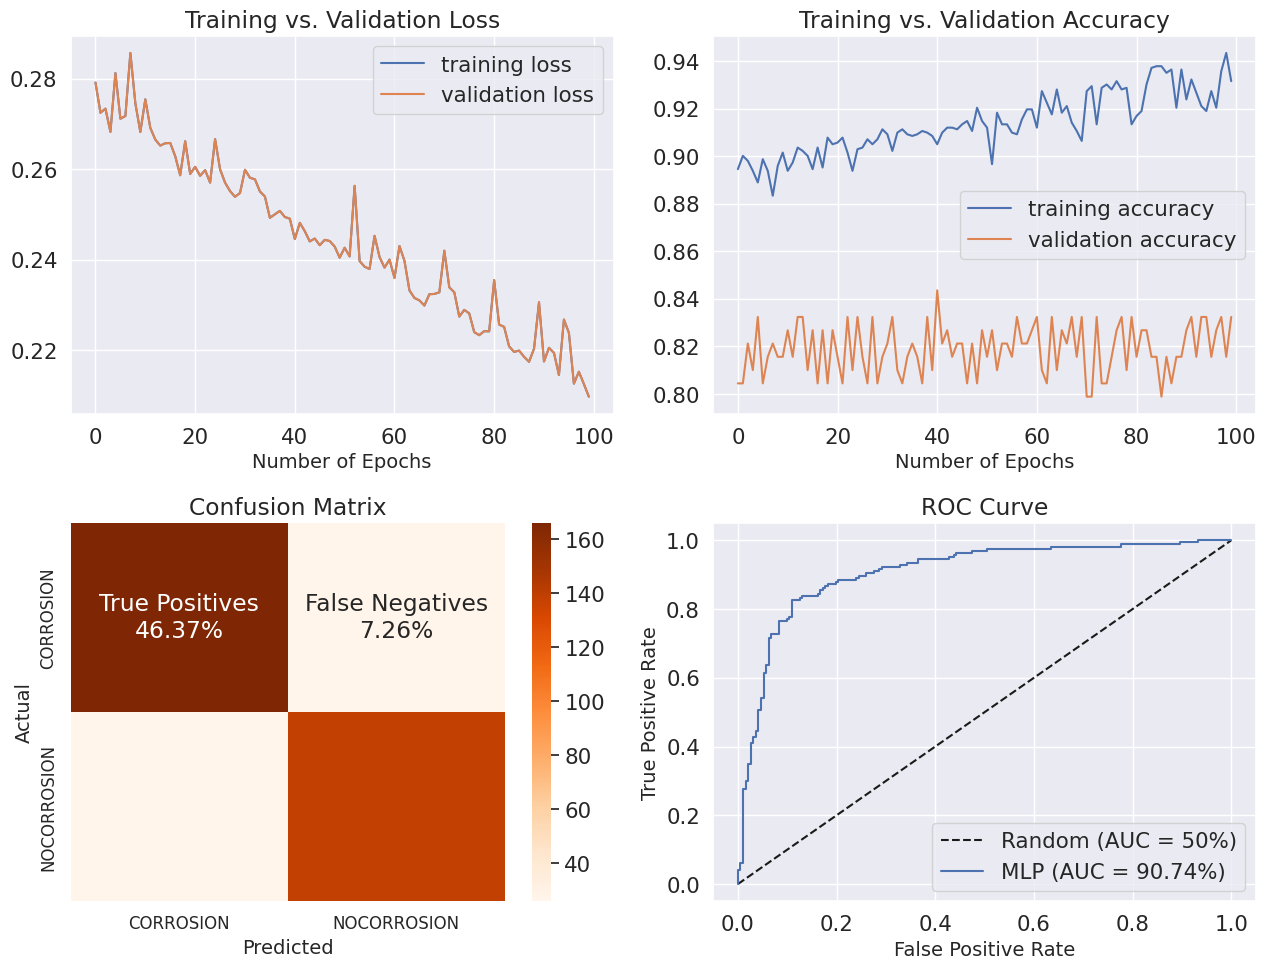

In [36]:
create_charts(mlp, X_train, y_train, X_test, y_test)

In [37]:
def print_mlp_summary(mlp):
    print("MLP Model Summary:")
    print("===================")
    print("Number of Layers:", mlp.n_layers_)
    print("Number of Neurons in Each Layer:", mlp.hidden_layer_sizes)
    print("Activation Function:", mlp.activation)
    print("Solver (Optimization Algorithm):", mlp.solver)
    print("Alpha (L2 Regularization):", mlp.alpha)
    print("Learning Rate:", mlp.learning_rate)
    print("Learning Rate Schedule:", mlp.learning_rate_init)
    print("Maximum Number of Iterations:", mlp.max_iter)
    print("Training Loss:", mlp.loss_)
    print("Output Activation Function:", "logistic" if mlp.out_activation_ == "logistic" else "tanh" if mlp.out_activation_ == "tanh" else "identity")

def count_parameters(model):
    total_params = 0
    for layer in model.coefs_:
        total_params += layer.size
    return total_params


# Print the summary
print_mlp_summary(mlp)
total_parameters = count_parameters(mlp)
print("Total Number of Parameters in the MLP model:", total_parameters)

MLP Model Summary:
Number of Layers: 4
Number of Neurons in Each Layer: (100, 50)
Activation Function: relu
Solver (Optimization Algorithm): adam
Alpha (L2 Regularization): 0.0005
Learning Rate: constant
Learning Rate Schedule: 0.001
Maximum Number of Iterations: 200
Training Loss: 0.20978064646468533
Output Activation Function: logistic
Total Number of Parameters in the MLP model: 6558650


In [ ]:
# Save the trained MLP model to a file
model_filename = './model/mlp_lbp_model.pkl'
joblib.dump(mlp, model_filename)

print(f"MLP model saved as {model_filename}")

MLP model saved as ./model/mlp_lbp_model.pkl


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.8840782122905028
Test Accuracy: 0.840782122905028
Precision: 0.8400219814727587
Recall: 0.8397339357429718
F1 Score: 0.8398713069407933

Overall Accuracy:               precision    recall  f1-score   support

           0       0.85      0.85      0.85       192
           1       0.83      0.83      0.83       166

    accuracy                           0.84       358
   macro avg       0.84      0.84      0.84       358
weighted avg       0.84      0.84      0.84       358

Test Accuracy: 84.08%


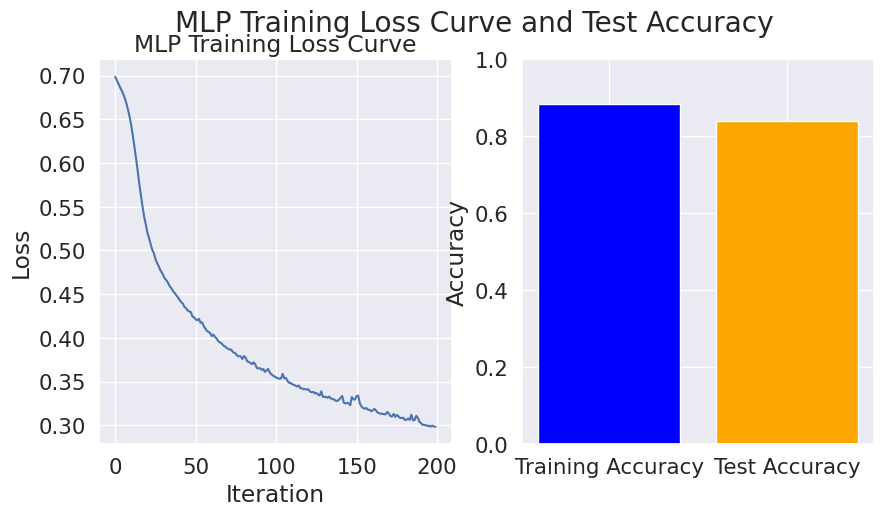

In [40]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(50, 50), alpha=0.0005, max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

[Summary Statistics]
Accuracy = 85.20% | Precision = 85.28% | Recall = 87.50% | Specificity = 82.53% | F1 Score = 86.38%


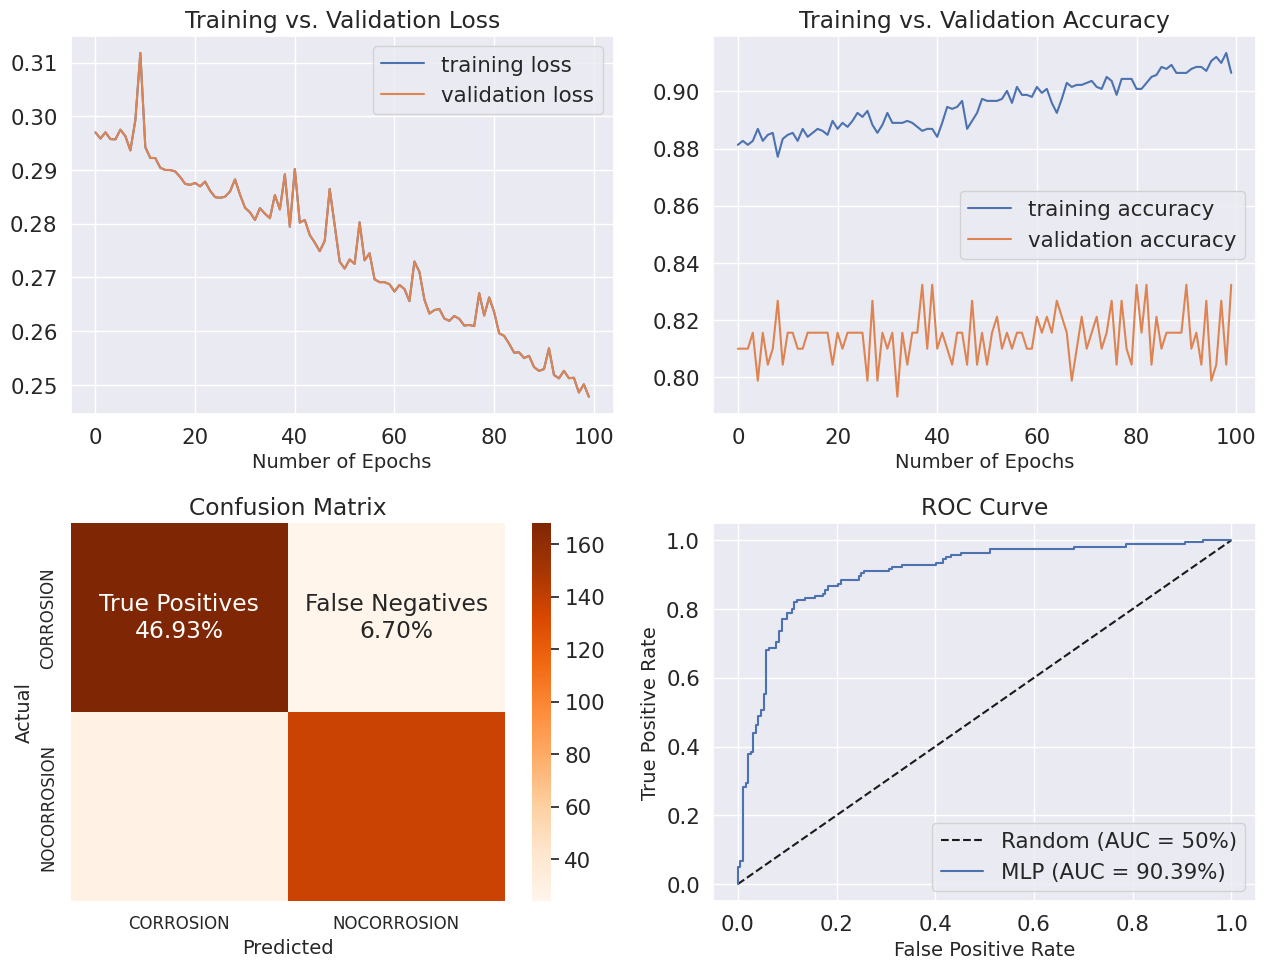

In [41]:
create_charts(mlp, X_train, y_train, X_test, y_test)

In [42]:
def print_mlp_summary(mlp):
    print("MLP Model Summary:")
    print("===================")
    print("Number of Layers:", mlp.n_layers_)
    print("Number of Neurons in Each Layer:", mlp.hidden_layer_sizes)
    print("Activation Function:", mlp.activation)
    print("Solver (Optimization Algorithm):", mlp.solver)
    print("Alpha (L2 Regularization):", mlp.alpha)
    print("Learning Rate:", mlp.learning_rate)
    print("Learning Rate Schedule:", mlp.learning_rate_init)
    print("Maximum Number of Iterations:", mlp.max_iter)
    print("Training Loss:", mlp.loss_)
    print("Output Activation Function:", "logistic" if mlp.out_activation_ == "logistic" else "tanh" if mlp.out_activation_ == "tanh" else "identity")

def count_parameters(model):
    total_params = 0
    for layer in model.coefs_:
        total_params += layer.size
    return total_params


# Print the summary
print_mlp_summary(mlp)
total_parameters = count_parameters(mlp)
print("Total Number of Parameters in the MLP model:", total_parameters)

MLP Model Summary:
Number of Layers: 4
Number of Neurons in Each Layer: (50, 50)
Activation Function: relu
Solver (Optimization Algorithm): adam
Alpha (L2 Regularization): 0.0005
Learning Rate: constant
Learning Rate Schedule: 0.001
Maximum Number of Iterations: 200
Training Loss: 0.24781933684822263
Output Activation Function: logistic
Total Number of Parameters in the MLP model: 3279350


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.8736033519553073
Test Accuracy: 0.8240223463687151
Precision: 0.8236434719551029
Recall: 0.8220695281124498
F1 Score: 0.8226928610174289

Overall Accuracy:               precision    recall  f1-score   support

           0       0.83      0.85      0.84       192
           1       0.82      0.80      0.81       166

    accuracy                           0.82       358
   macro avg       0.82      0.82      0.82       358
weighted avg       0.82      0.82      0.82       358

Test Accuracy: 82.40%


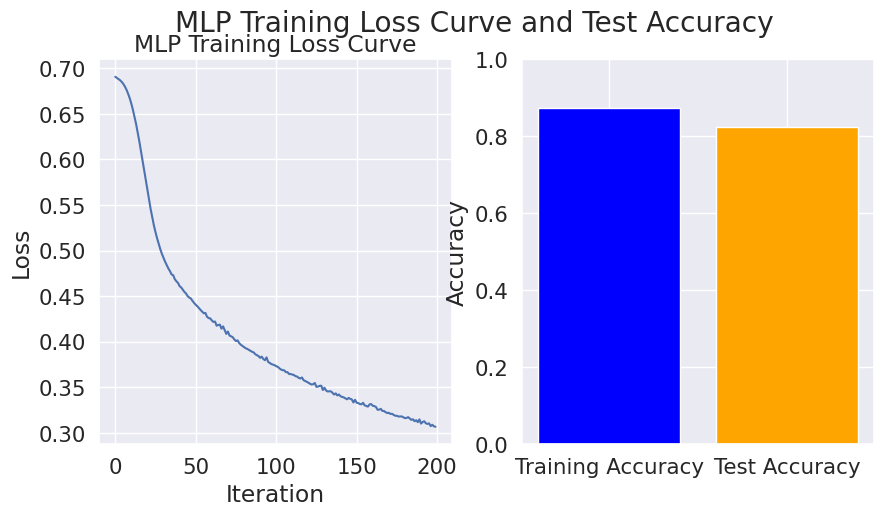

In [45]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 50), alpha=0.0005, max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

[Summary Statistics]
Accuracy = 82.96% | Precision = 85.03% | Recall = 82.81% | Specificity = 83.13% | F1 Score = 83.91%


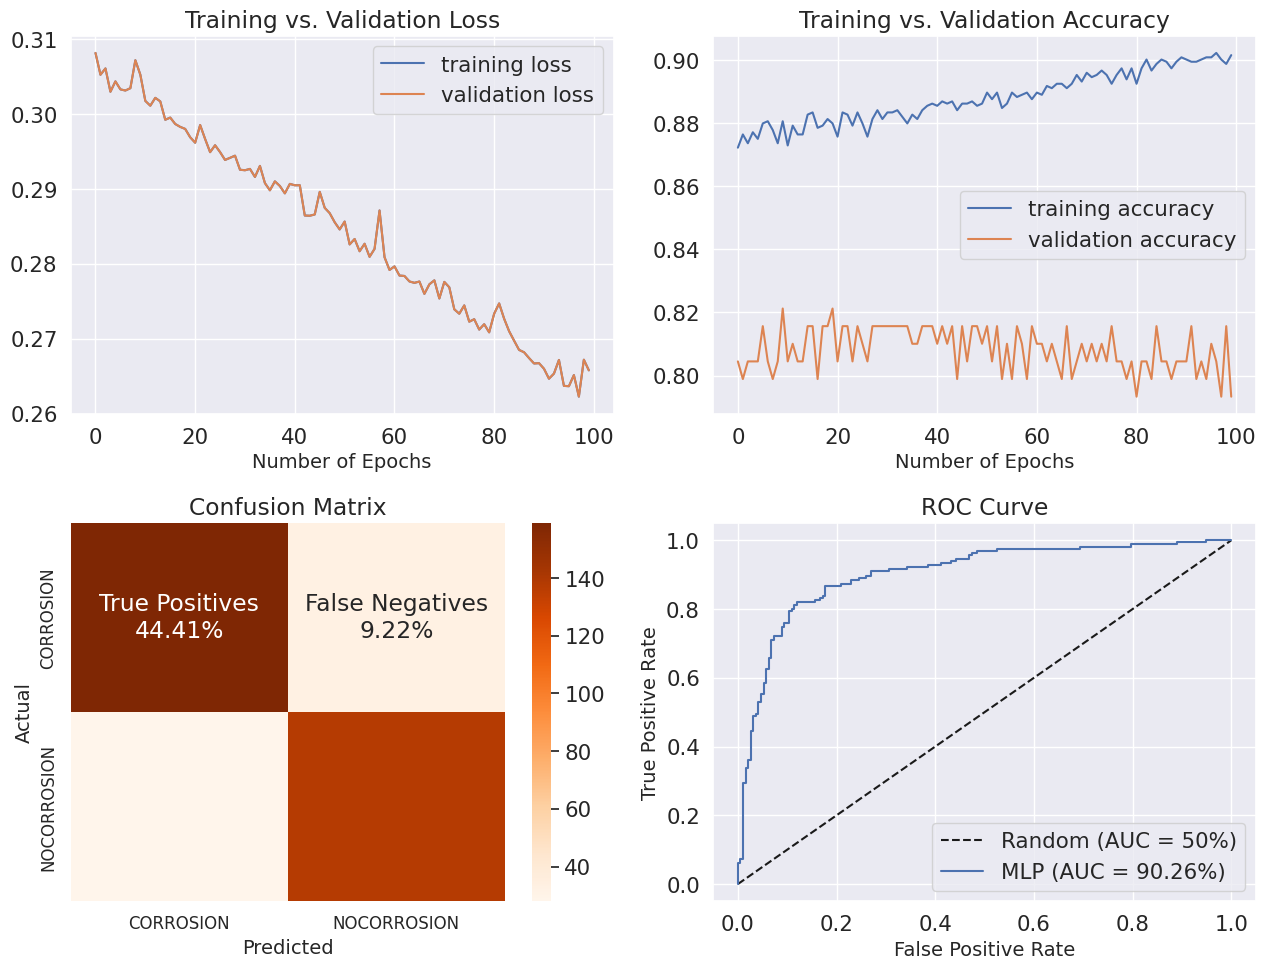

In [46]:
create_charts(mlp, X_train, y_train, X_test, y_test)

In [47]:
def print_mlp_summary(mlp):
    print("MLP Model Summary:")
    print("===================")
    print("Number of Layers:", mlp.n_layers_)
    print("Number of Neurons in Each Layer:", mlp.hidden_layer_sizes)
    print("Activation Function:", mlp.activation)
    print("Solver (Optimization Algorithm):", mlp.solver)
    print("Alpha (L2 Regularization):", mlp.alpha)
    print("Learning Rate:", mlp.learning_rate)
    print("Learning Rate Schedule:", mlp.learning_rate_init)
    print("Maximum Number of Iterations:", mlp.max_iter)
    print("Training Loss:", mlp.loss_)
    print("Output Activation Function:", "logistic" if mlp.out_activation_ == "logistic" else "tanh" if mlp.out_activation_ == "tanh" else "identity")

def count_parameters(model):
    total_params = 0
    for layer in model.coefs_:
        total_params += layer.size
    return total_params


# Print the summary
print_mlp_summary(mlp)
total_parameters = count_parameters(mlp)
print("Total Number of Parameters in the MLP model:", total_parameters)

MLP Model Summary:
Number of Layers: 4
Number of Neurons in Each Layer: (10, 50)
Activation Function: relu
Solver (Optimization Algorithm): adam
Alpha (L2 Regularization): 0.0005
Learning Rate: constant
Learning Rate Schedule: 0.001
Maximum Number of Iterations: 200
Training Loss: 0.2657701521177069
Output Activation Function: logistic
Total Number of Parameters in the MLP model: 655910


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.8966480446927374
Test Accuracy: 0.835195530726257
Precision: 0.834209949594565
Recall: 0.834933483935743
F1 Score: 0.8345124769851531

Overall Accuracy:               precision    recall  f1-score   support

           0       0.85      0.84      0.85       192
           1       0.82      0.83      0.82       166

    accuracy                           0.84       358
   macro avg       0.83      0.83      0.83       358
weighted avg       0.84      0.84      0.84       358

Test Accuracy: 83.52%


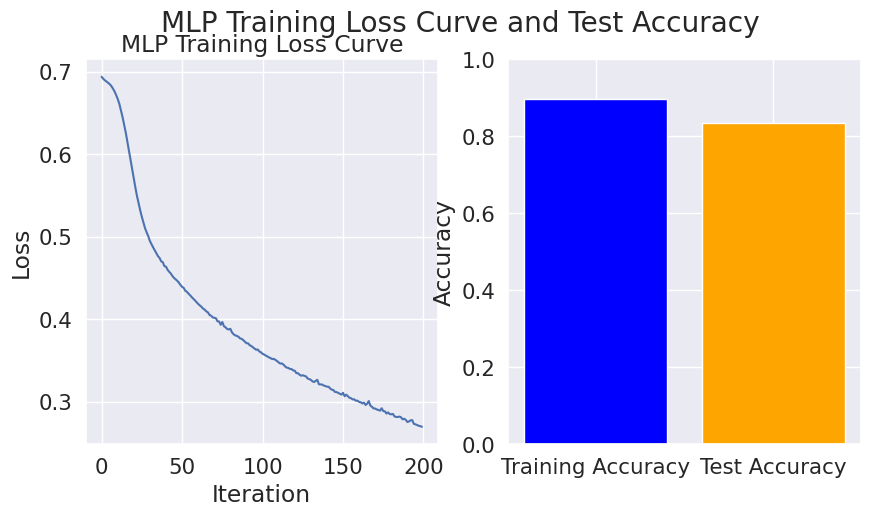

In [50]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 50), max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

[Summary Statistics]
Accuracy = 83.52% | Precision = 84.82% | Recall = 84.38% | Specificity = 82.53% | F1 Score = 84.60%


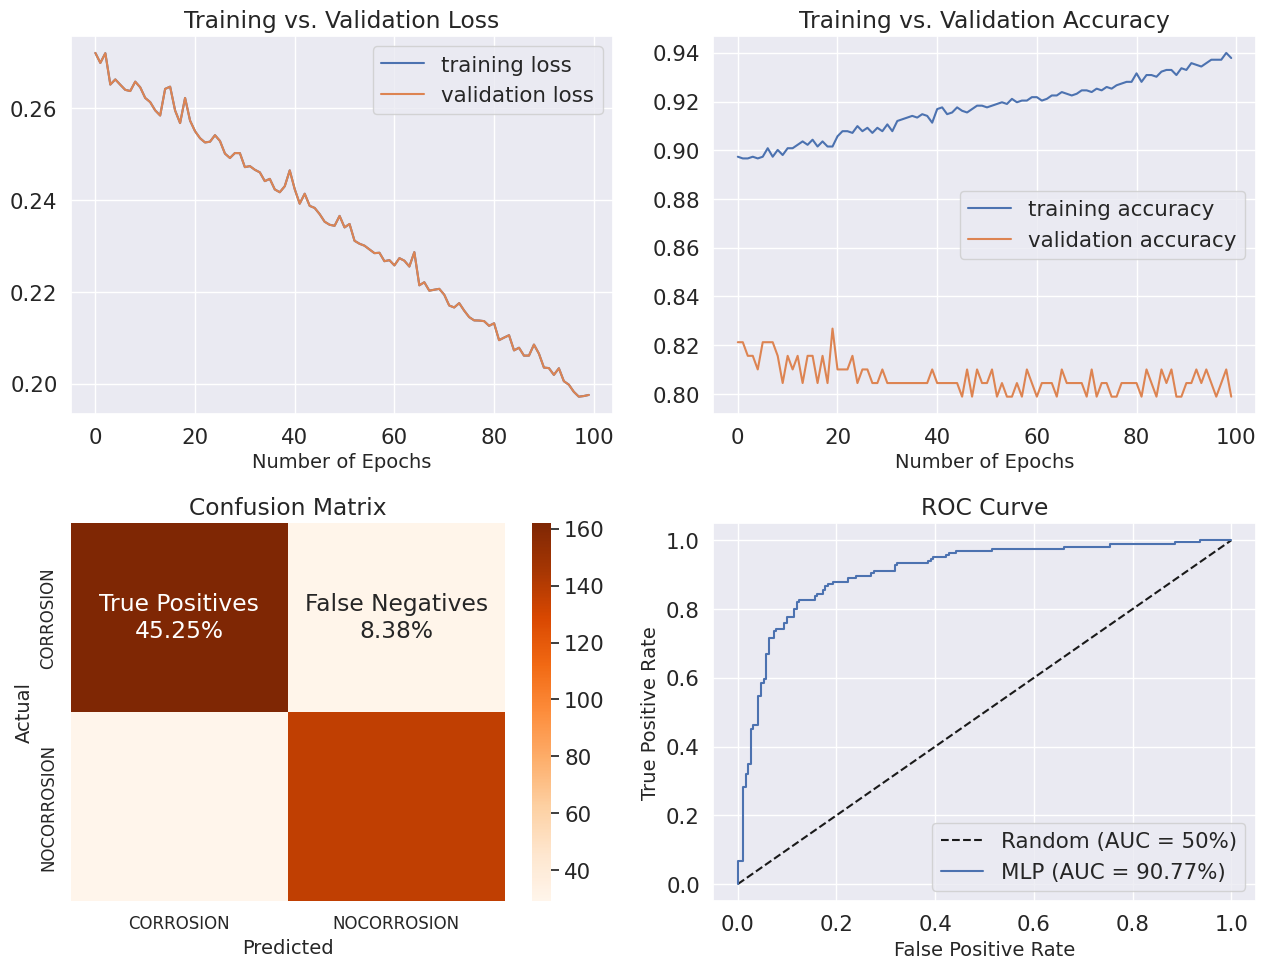

In [51]:
create_charts(mlp, X_train, y_train, X_test, y_test)

In [53]:
def print_mlp_summary(mlp):
    print("MLP Model Summary:")
    print("===================")
    print("Number of Layers:", mlp.n_layers_)
    print("Number of Neurons in Each Layer:", mlp.hidden_layer_sizes)
    print("Activation Function:", mlp.activation)
    print("Solver (Optimization Algorithm):", mlp.solver)
    print("Alpha (L2 Regularization):", mlp.alpha)
    print("Learning Rate:", mlp.learning_rate)
    print("Learning Rate Schedule:", mlp.learning_rate_init)
    print("Maximum Number of Iterations:", mlp.max_iter)
    print("Training Loss:", mlp.loss_)
    print("Output Activation Function:", "logistic" if mlp.out_activation_ == "logistic" else "tanh" if mlp.out_activation_ == "tanh" else "identity")

def count_parameters(model):
    total_params = 0
    for layer in model.coefs_:
        total_params += layer.size
    return total_params


# Print the summary
print_mlp_summary(mlp)
total_parameters = count_parameters(mlp)
print("Total Number of Parameters in the MLP model:", total_parameters)

MLP Model Summary:
Number of Layers: 4
Number of Neurons in Each Layer: (10, 50)
Activation Function: relu
Solver (Optimization Algorithm): adam
Alpha (L2 Regularization): 0.0001
Learning Rate: constant
Learning Rate Schedule: 0.001
Maximum Number of Iterations: 200
Training Loss: 0.19756638603991916
Output Activation Function: logistic
Total Number of Parameters in the MLP model: 655910


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.854050279329609
Test Accuracy: 0.8072625698324022
Precision: 0.8074436733529804
Recall: 0.8044051204819277
F1 Score: 0.8054025949471793

Overall Accuracy:               precision    recall  f1-score   support

           0       0.81      0.84      0.82       192
           1       0.81      0.77      0.79       166

    accuracy                           0.81       358
   macro avg       0.81      0.80      0.81       358
weighted avg       0.81      0.81      0.81       358

Test Accuracy: 80.73%


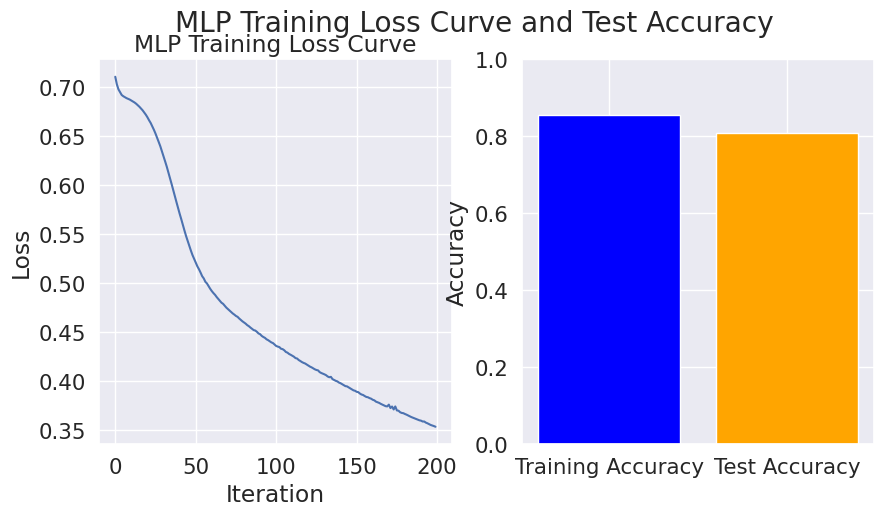

In [56]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(5, 50), max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

[Summary Statistics]
Accuracy = 82.40% | Precision = 82.74% | Recall = 84.90% | Specificity = 79.52% | F1 Score = 83.80%


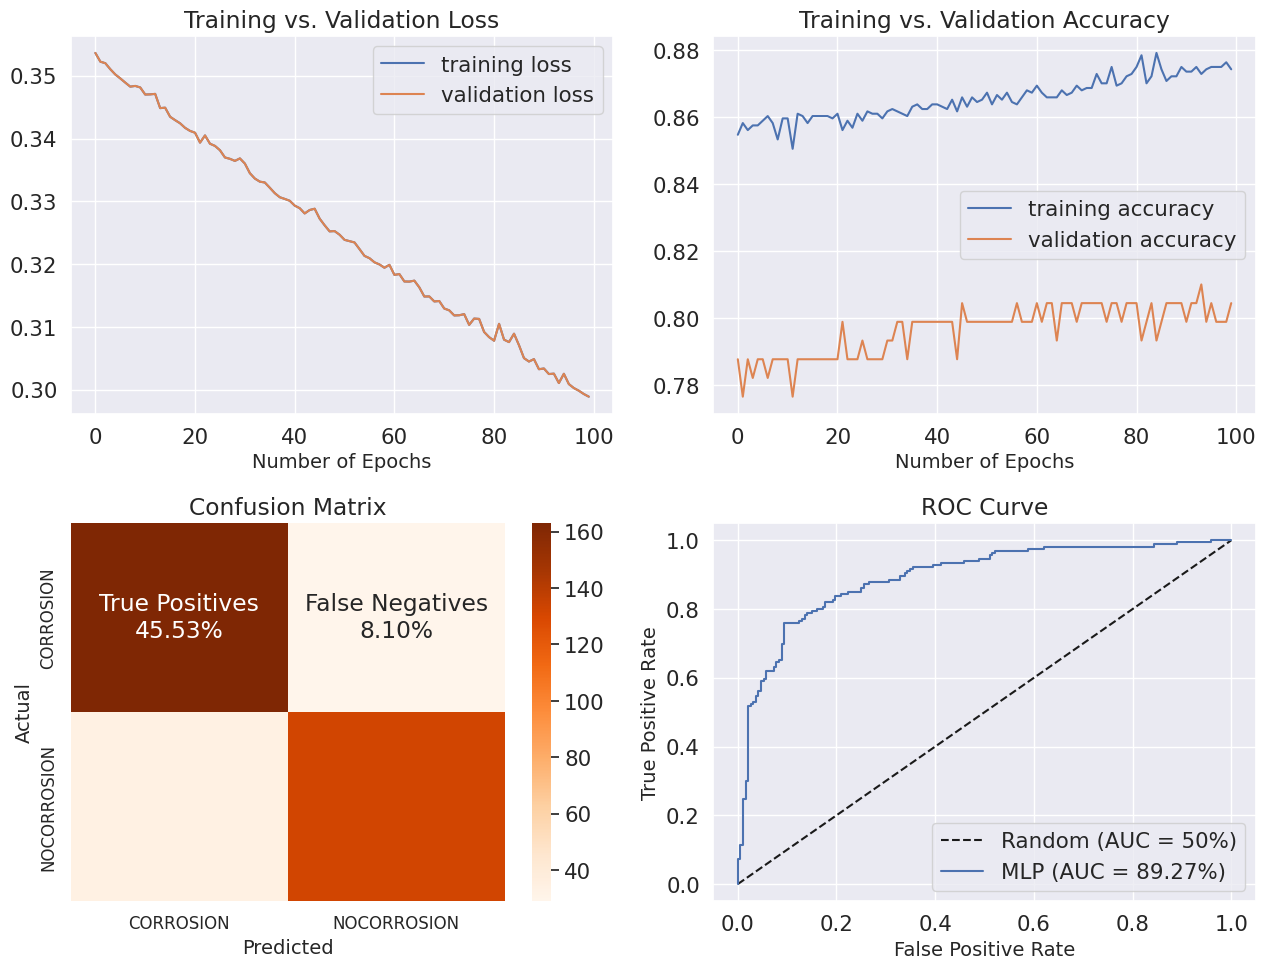

In [57]:
create_charts(mlp, X_train, y_train, X_test, y_test)

In [58]:
def print_mlp_summary(mlp):
    print("MLP Model Summary:")
    print("===================")
    print("Number of Layers:", mlp.n_layers_)
    print("Number of Neurons in Each Layer:", mlp.hidden_layer_sizes)
    print("Activation Function:", mlp.activation)
    print("Solver (Optimization Algorithm):", mlp.solver)
    print("Alpha (L2 Regularization):", mlp.alpha)
    print("Learning Rate:", mlp.learning_rate)
    print("Learning Rate Schedule:", mlp.learning_rate_init)
    print("Maximum Number of Iterations:", mlp.max_iter)
    print("Training Loss:", mlp.loss_)
    print("Output Activation Function:", "logistic" if mlp.out_activation_ == "logistic" else "tanh" if mlp.out_activation_ == "tanh" else "identity")

def count_parameters(model):
    total_params = 0
    for layer in model.coefs_:
        total_params += layer.size
    return total_params


# Print the summary
print_mlp_summary(mlp)
total_parameters = count_parameters(mlp)
print("Total Number of Parameters in the MLP model:", total_parameters)

MLP Model Summary:
Number of Layers: 4
Number of Neurons in Each Layer: (5, 50)
Activation Function: relu
Solver (Optimization Algorithm): adam
Alpha (L2 Regularization): 0.0001
Learning Rate: constant
Learning Rate Schedule: 0.001
Maximum Number of Iterations: 200
Training Loss: 0.2989202710901366
Output Activation Function: logistic
Total Number of Parameters in the MLP model: 327980


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home

Training Accuracy: 0.5391061452513967
Test Accuracy: 0.5363128491620112
Precision: 0.2681564245810056
Recall: 0.5
F1 Score: 0.3490909090909091

Overall Accuracy:               precision    recall  f1-score   support

           0       0.54      1.00      0.70       192
           1       0.00      0.00      0.00       166

    accuracy                           0.54       358
   macro avg       0.27      0.50      0.35       358
weighted avg       0.29      0.54      0.37       358

Test Accuracy: 53.63%


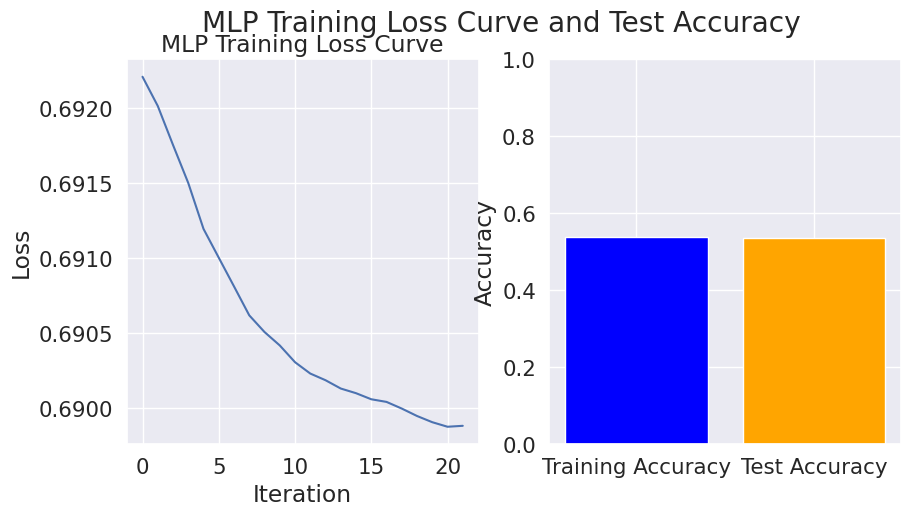

In [61]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(5, 50), max_iter=200, solver='sgd')
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

[Summary Statistics]
Accuracy = 53.63% | Precision = 53.63% | Recall = 100.00% | Specificity = 0.00% | F1 Score = 69.82%


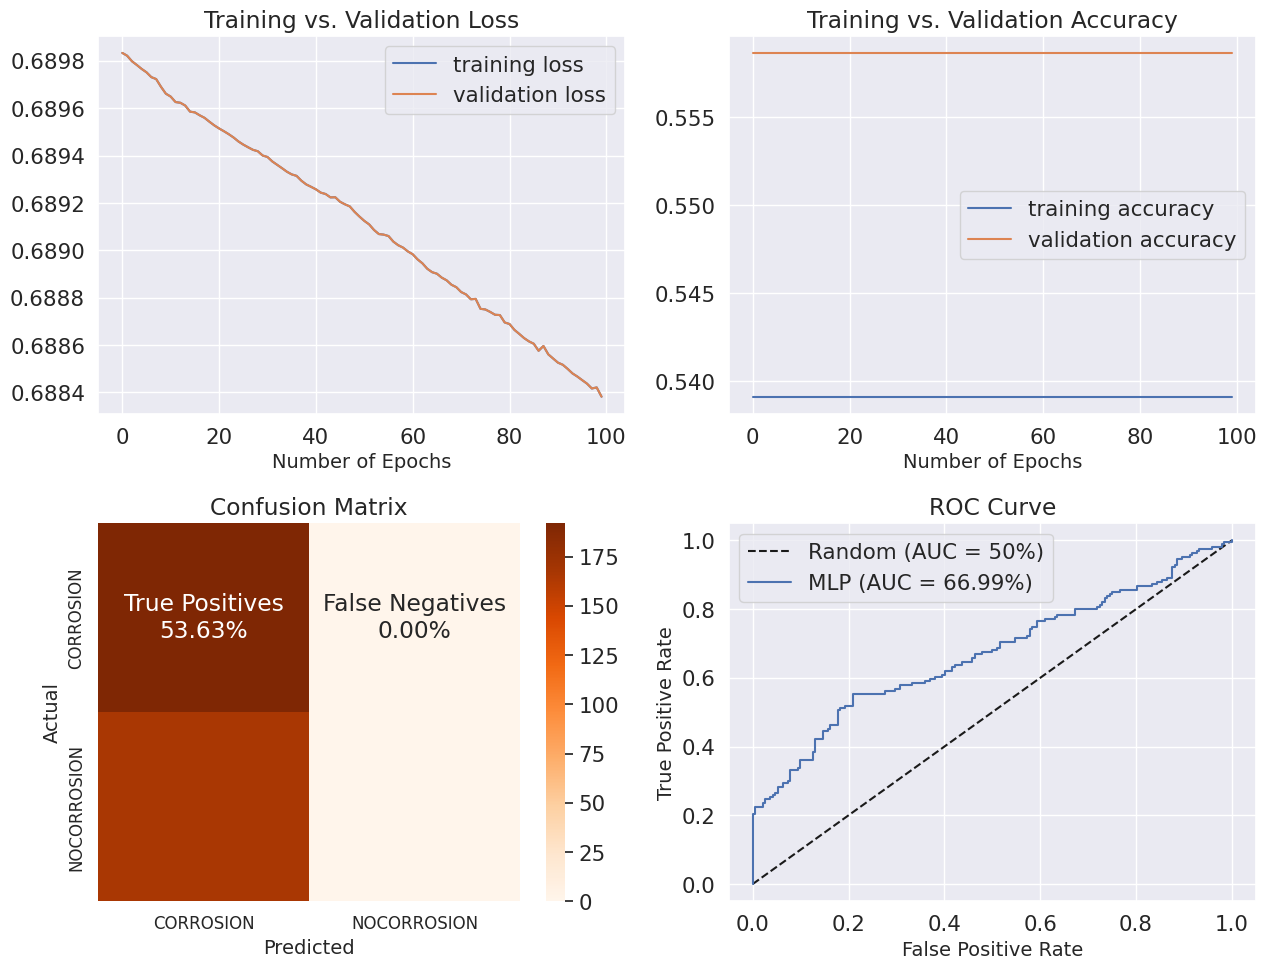

In [62]:
create_charts(mlp, X_train, y_train, X_test, y_test)

In [63]:
def print_mlp_summary(mlp):
    print("MLP Model Summary:")
    print("===================")
    print("Number of Layers:", mlp.n_layers_)
    print("Number of Neurons in Each Layer:", mlp.hidden_layer_sizes)
    print("Activation Function:", mlp.activation)
    print("Solver (Optimization Algorithm):", mlp.solver)
    print("Alpha (L2 Regularization):", mlp.alpha)
    print("Learning Rate:", mlp.learning_rate)
    print("Learning Rate Schedule:", mlp.learning_rate_init)
    print("Maximum Number of Iterations:", mlp.max_iter)
    print("Training Loss:", mlp.loss_)
    print("Output Activation Function:", "logistic" if mlp.out_activation_ == "logistic" else "tanh" if mlp.out_activation_ == "tanh" else "identity")

def count_parameters(model):
    total_params = 0
    for layer in model.coefs_:
        total_params += layer.size
    return total_params


# Print the summary
print_mlp_summary(mlp)
total_parameters = count_parameters(mlp)
print("Total Number of Parameters in the MLP model:", total_parameters)

MLP Model Summary:
Number of Layers: 4
Number of Neurons in Each Layer: (5, 50)
Activation Function: relu
Solver (Optimization Algorithm): sgd
Alpha (L2 Regularization): 0.0001
Learning Rate: constant
Learning Rate Schedule: 0.001
Maximum Number of Iterations: 200
Training Loss: 0.6883823248179234
Output Activation Function: logistic
Total Number of Parameters in the MLP model: 327980


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home

Training Accuracy: 0.5391061452513967
Test Accuracy: 0.5363128491620112
Precision: 0.2681564245810056
Recall: 0.5
F1 Score: 0.3490909090909091

Overall Accuracy:               precision    recall  f1-score   support

           0       0.54      1.00      0.70       192
           1       0.00      0.00      0.00       166

    accuracy                           0.54       358
   macro avg       0.27      0.50      0.35       358
weighted avg       0.29      0.54      0.37       358

Test Accuracy: 53.63%


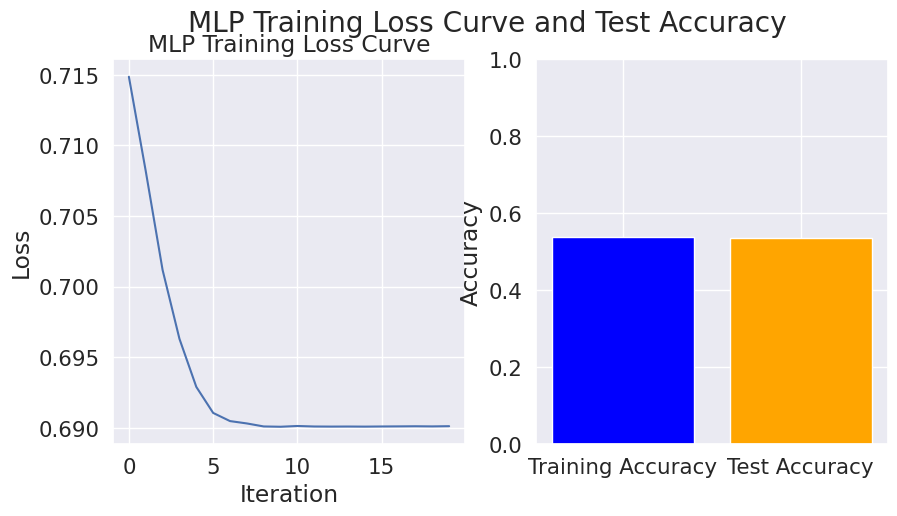

In [76]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(5, 50), solver='sgd', activation='logistic', max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

[Summary Statistics]
Accuracy = 53.63% | Precision = 53.63% | Recall = 100.00% | Specificity = 0.00% | F1 Score = 69.82%


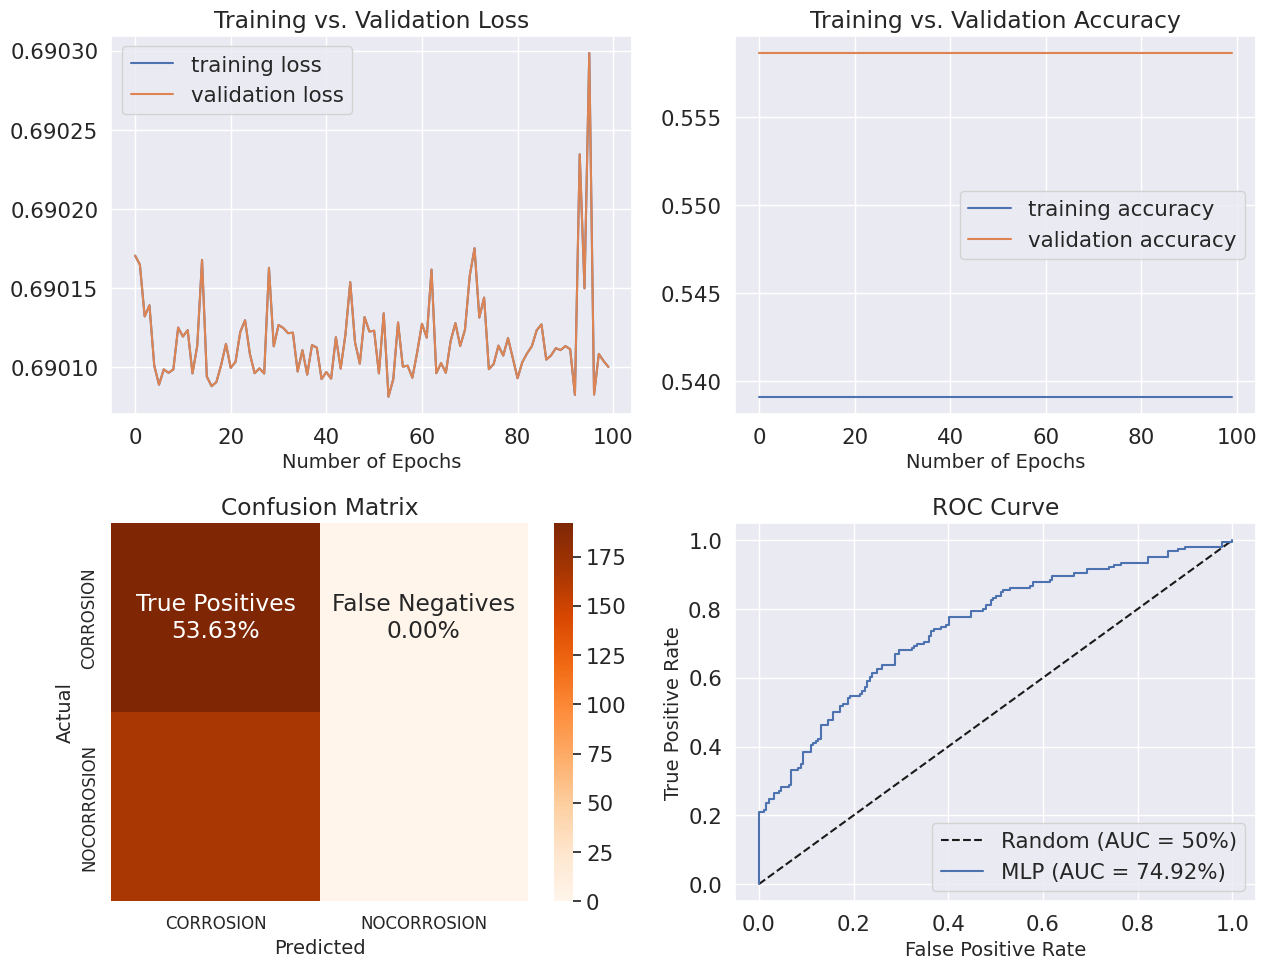

In [77]:
create_charts(mlp, X_train, y_train, X_test, y_test)

In [78]:
def print_mlp_summary(mlp):
    print("MLP Model Summary:")
    print("===================")
    print("Number of Layers:", mlp.n_layers_)
    print("Number of Neurons in Each Layer:", mlp.hidden_layer_sizes)
    print("Activation Function:", mlp.activation)
    print("Solver (Optimization Algorithm):", mlp.solver)
    print("Alpha (L2 Regularization):", mlp.alpha)
    print("Learning Rate:", mlp.learning_rate)
    print("Learning Rate Schedule:", mlp.learning_rate_init)
    print("Maximum Number of Iterations:", mlp.max_iter)
    print("Training Loss:", mlp.loss_)
    print("Output Activation Function:", "logistic" if mlp.out_activation_ == "logistic" else "tanh" if mlp.out_activation_ == "tanh" else "identity")

def count_parameters(model):
    total_params = 0
    for layer in model.coefs_:
        total_params += layer.size
    return total_params


# Print the summary
print_mlp_summary(mlp)
total_parameters = count_parameters(mlp)
print("Total Number of Parameters in the MLP model:", total_parameters)

MLP Model Summary:
Number of Layers: 4
Number of Neurons in Each Layer: (5, 50)
Activation Function: logistic
Solver (Optimization Algorithm): sgd
Alpha (L2 Regularization): 0.0001
Learning Rate: constant
Learning Rate Schedule: 0.001
Maximum Number of Iterations: 200
Training Loss: 0.6901002478038201
Output Activation Function: logistic
Total Number of Parameters in the MLP model: 327980
